This is a Jupyter Notebook.

To run a cell, type `Shift` + `Return`. Run the cell below to get started

In [1]:
from workshop_utils import * 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Edits Per Hour Example

_Tacloban, Philippines_

These next cells will load the output from the following query in Athena:

```sql
SELECT date_trunc('hour', updated), avg( date_diff('minute', updated, valid_until) ) AS avg_lifespan_minutes, count(distinct(changesets.uid)) AS num_users, count(*) AS edits, count(distinct(southeastern_asia.id)) AS objects
FROM southeastern_asia
JOIN changesets
    ON southeastern_asia.changeset = changesets.id
WHERE ST_WITHIN( geom , ST_Polygon('POLYGON((124.980451 11.265362, 125.03352 11.265362, 125.03352 11.17746, 124.980451 11.17746, 124.980451 11.265362))') )
GROUP BY  date_trunc('hour', updated)
```

In [30]:
#Tacloban, Philippines by hour: 
tacloban = load_dataframe_from_s3('https://us-east-2.console.aws.amazon.com/athena/query/results/9d4d492b-6c32-43f0-9266-a1e93ca08aac/csv')


Found file locally... Creating dataframe... done.  Found 1,320 rows

In [31]:
tacloban.head(2)

,_col0,avg_lifespan_minutes,num_users,edits,objects
0,2014-06-01 06:00:00.000,508230.107143,1,56,50
1,2013-11-13 15:00:00.000,5348.135849,4,835,835


In [32]:
#Rename the columns so they make more sense
tacloban.columns = ["date", "lifespan_minutes", "num_users", "edits", "objects"]

#Cast the date as date
tacloban['datetime'] = tacloban.date.apply(pd.Timestamp)

#Reindex (and sort)by date becuase the original query was organized that way
tacloban.set_index('datetime', inplace=True)
tacloban.sort_index(inplace=True)

#Add two new columns:
tacloban['lifespan_days'] = tacloban.lifespan_minutes.apply(lambda x: x/(60*24))
tacloban['object_percent'] = tacloban.objects / tacloban.objects.sum()

#Finally, show the new dataframe
tacloban.head(3)

,date,lifespan_minutes,num_users,edits,objects,lifespan_days,object_percent
datetime,,,,,,,
2007-03-04 01:00:00,2007-03-04 01:00:00.000,895960.0,1,1,1,622.194444,0.000012
2007-03-04 02:00:00,2007-03-04 02:00:00.000,895914.0,1,3,3,622.162500,0.000037
2007-03-04 03:00:00,2007-03-04 03:00:00.000,895840.0,1,1,1,622.111111,0.000012


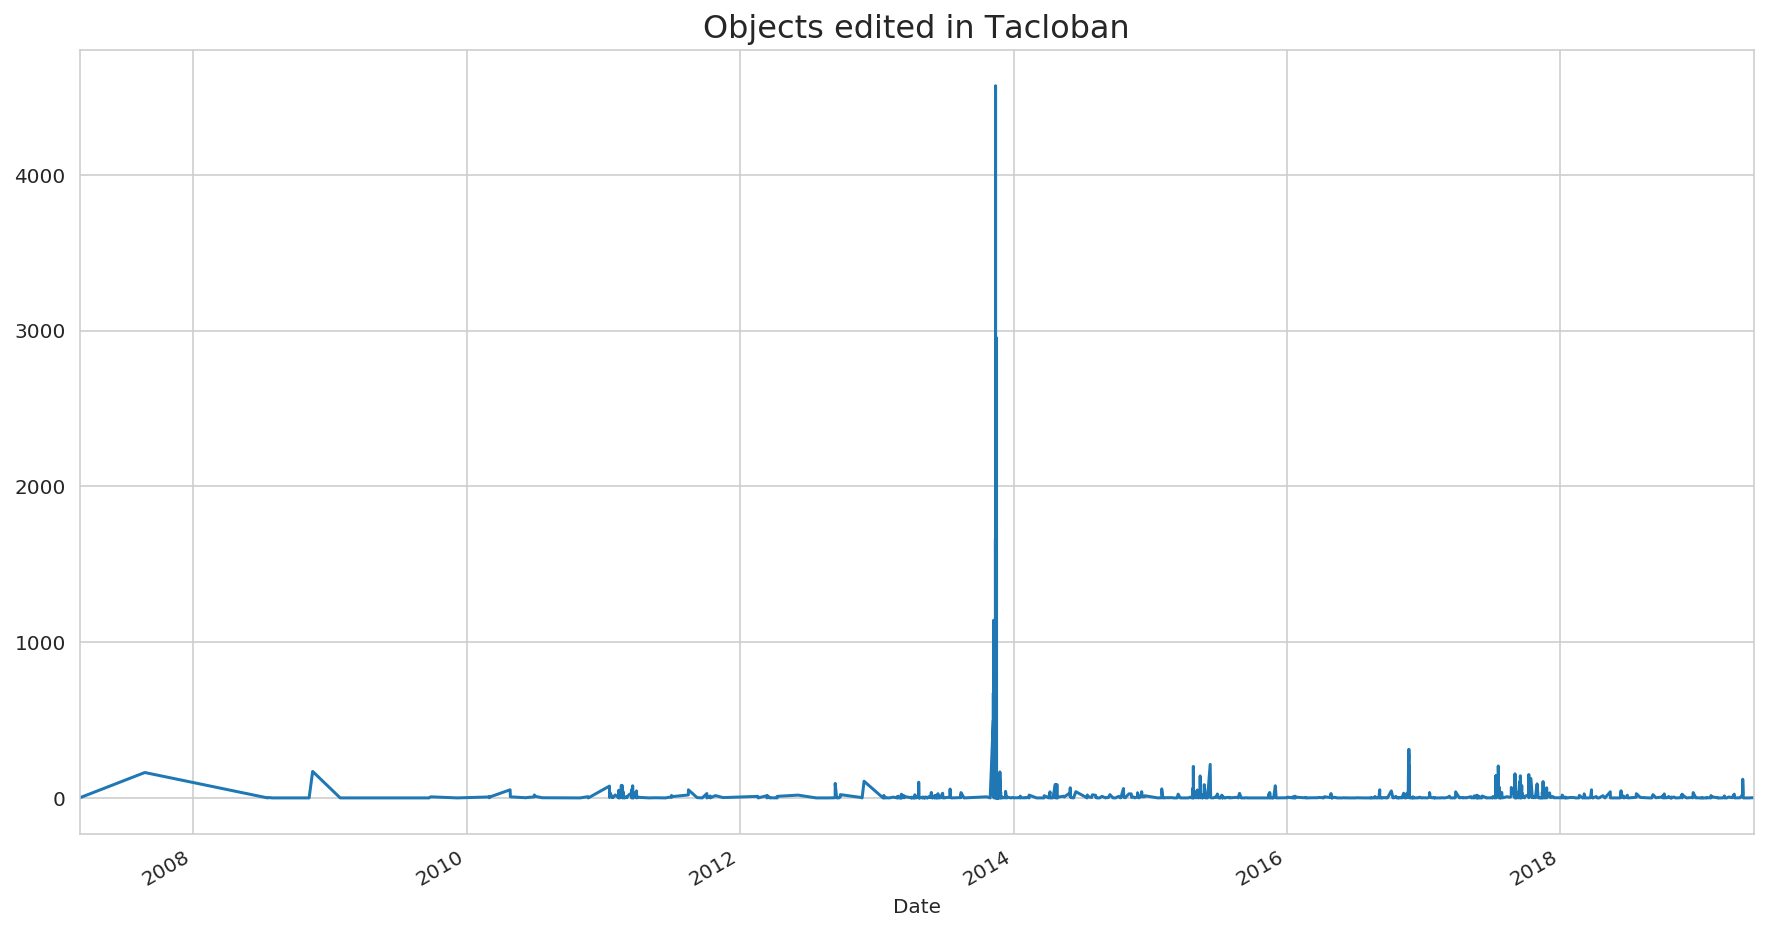

In [33]:
sns.set_style('whitegrid')
# fig, ax = plt.subplots(figsize=(15,7))
ax = tacloban['objects'].plot(figsize=(15,8))
ax.set_xlabel("Date"); ax.set_ylabel(""); 
ax.set_title("Objects edited in Tacloban",fontsize=16);

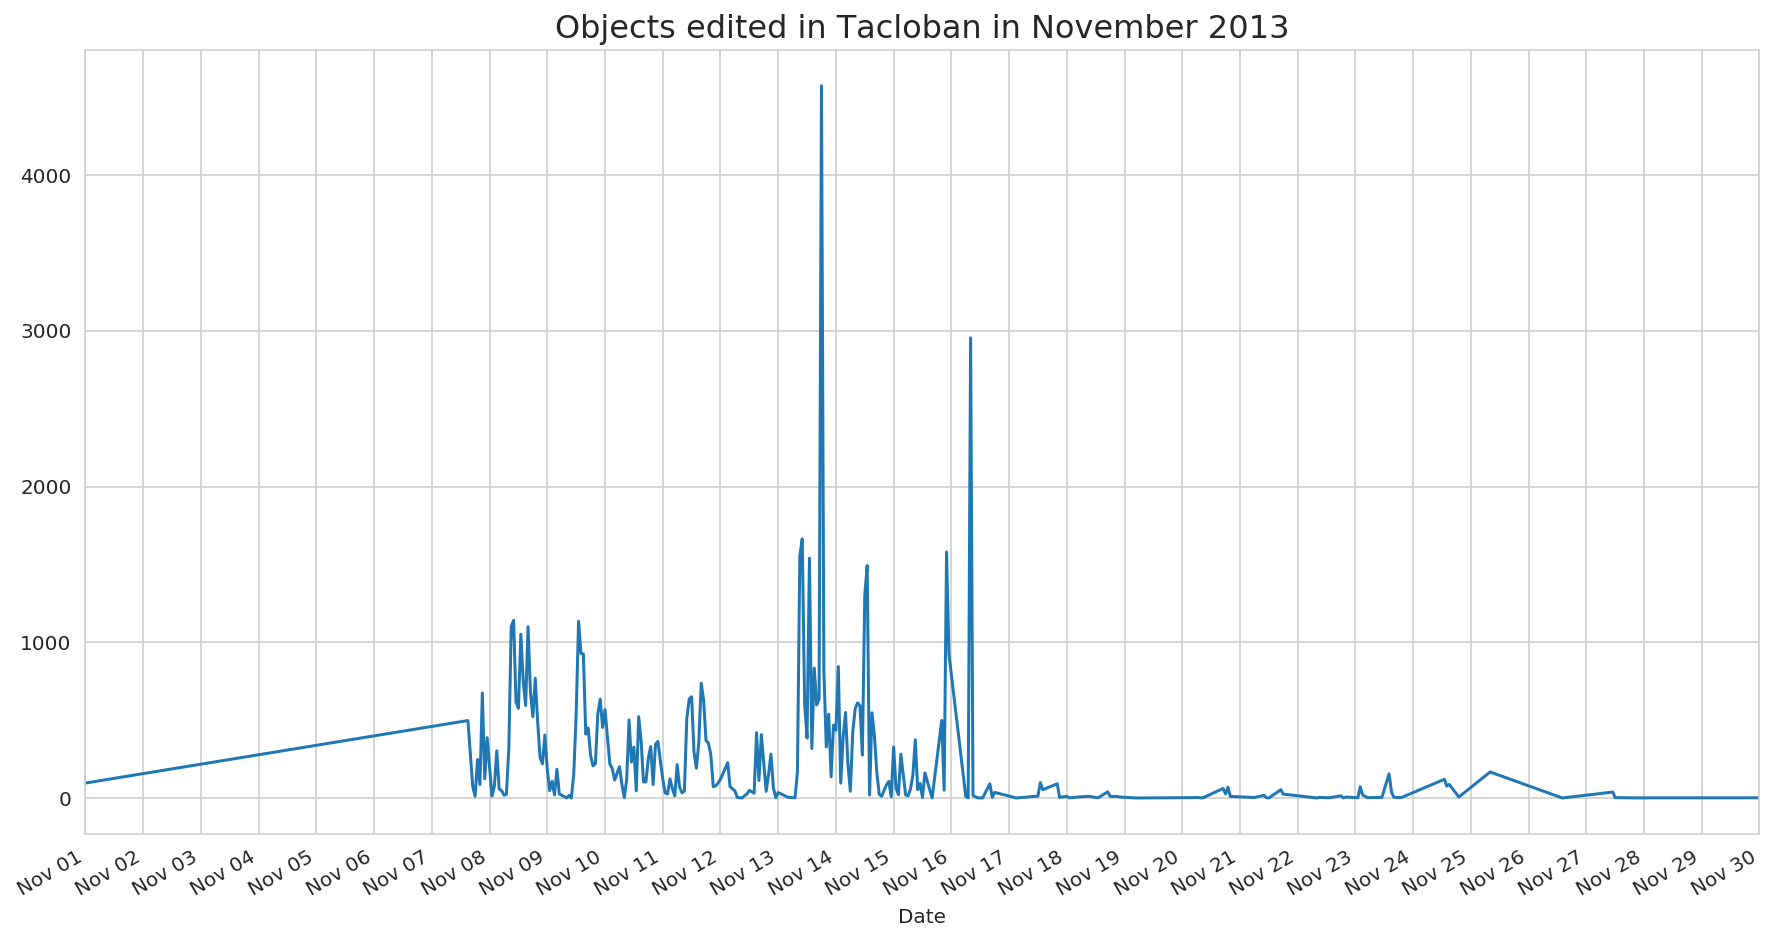

In [34]:
# Same plot, but zoom in on November 2013: 

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(15,7))
tacloban['objects'].plot(figsize=(15,8), ax=ax)
ax.set_xlabel("Date"); ax.set_ylabel(""); 
ax.set_title("Objects edited in Tacloban in November 2013",fontsize=16);
ax.set_xlim([datetime.date(2013,11,1), datetime.date(2013,11,30)])

#set ticks every day
ax.xaxis.set_major_locator(mdates.DayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

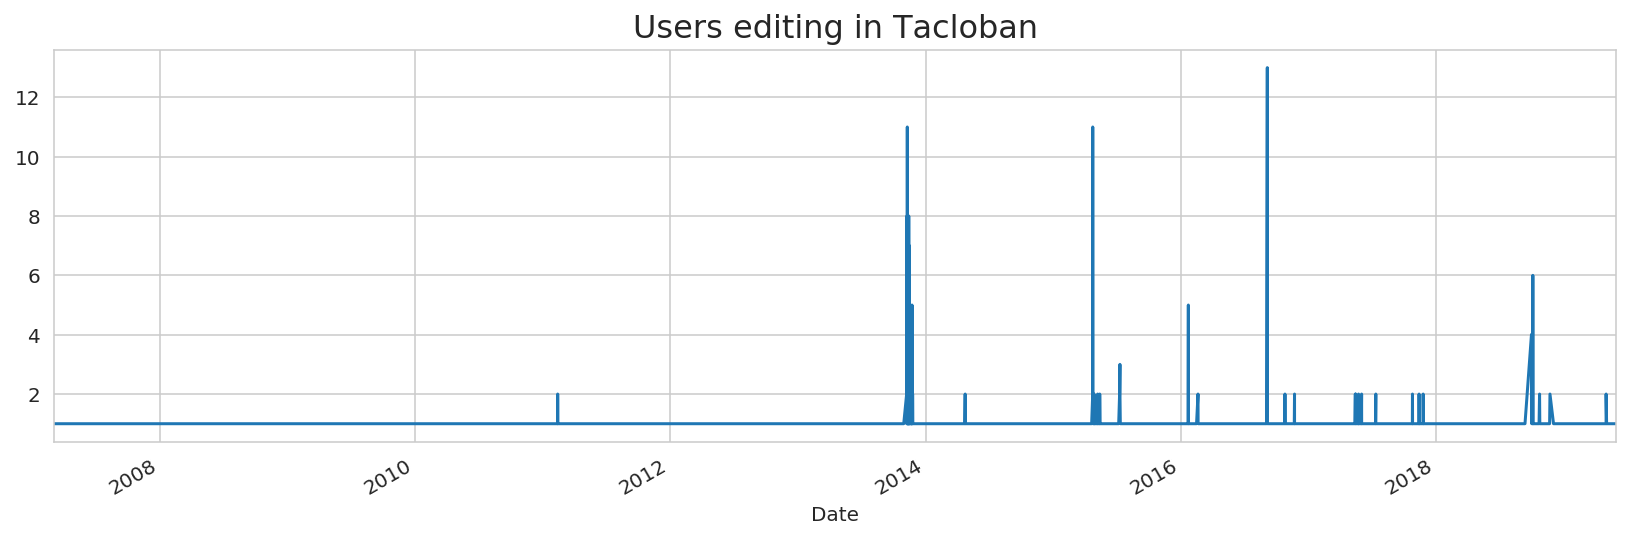

In [37]:
# How many users are editing the map here each day?
ax = tacloban['num_users'].plot(figsize=(14,4))
ax.set_xlabel("Date"); ax.set_ylabel("");
ax.set_title("Users editing in Tacloban",fontsize=16);
# ax.set_xlim([datetime.date(2013,11,1), datetime.date(2013,11,30)])


In [38]:
print("In total, the number of edits in Tacloban is: {:,}".format(tacloban.edits.sum()))

In total, the number of edits in Tacloban is: 83,550


## Now retrieve all of the actual buildings from Athena 


    SELECT southeastern_asia.id AS id,
             southeastern_asia.type AS type,
             southeastern_asia.geom AS geom,
             southeastern_asia.tags AS b_tags,
             southeastern_asia.changeset,
             southeastern_asia.updated,
             southeastern_asia.valid_until,
             southeastern_asia.version,
             southeastern_asia.minor_version,
             changesets.id,
             changesets.uid,
             changesets.user,
             changesets.tags AS c_tags
    FROM southeastern_asia
    JOIN changesets
        ON southeastern_asia.changeset = changesets.id
    WHERE ST_WITHIN( geom , ST_Polygon('POLYGON((124.980451 11.265362, 125.03352 11.265362, 125.03352 11.17746, 124.980451 11.17746, 124.980451 11.265362))') )
            AND element_at(southeastern_asia.tags, 'building') IS NOT NULL

In [95]:
buildings = load_dataframe_from_s3('https://us-east-2.console.aws.amazon.com/athena/query/results/ee27fe22-930e-4190-9c59-28a9afd6c5c6/csv')


Found file locally... Creating dataframe... done.  Found 70,663 rows

In [96]:
buildings.head(2)

,id,type,geom,b_tags,changeset,updated,valid_until,version,minor_version,id.1,uid,user,c_tags
0,245299209,2,"POLYGON ((124.9973546 11.1929758, 124.9973695 ...",{building=yes},18798581,2013-11-09 13:04:26.000,2013-11-13 23:55:06.000,1,0,18798581,979530,jaldhaka,"{comment=Bahon, #hotosm-task-286 , source=Bing..."
1,245455062,2,"POLYGON ((125.0021127 11.2126605, 125.0021089 ...","{typhoon:damage=yes, source=WorldView-2,Digita...",18907304,2013-11-15 03:42:16.000,NaN,2,0,18907304,415250,Data411,"{comment=http://tasks.hotosm.org/job/350, crea..."


In [97]:
# Cast timestamp to a date
buildings['date'] = buildings.updated.apply(lambda x: pd.Timestamp(x).date())

In [141]:
# How about the edit lifespan (time between edits)
buildings['lifespan'] = buildings.apply(lambda row: pd.Timestamp(row.valid_until) - pd.Timestamp(row.updated), axis=1)

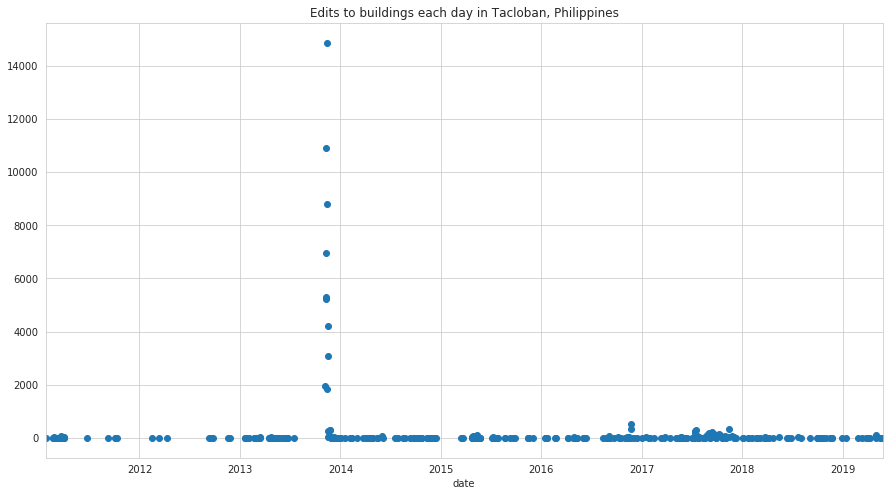

In [142]:
ax = buildings.groupby('date').aggregate('count')['id'].plot(style="o", figsize=(15,8))
ax.set_title("Edits to buildings each day in Tacloban, Philippines");

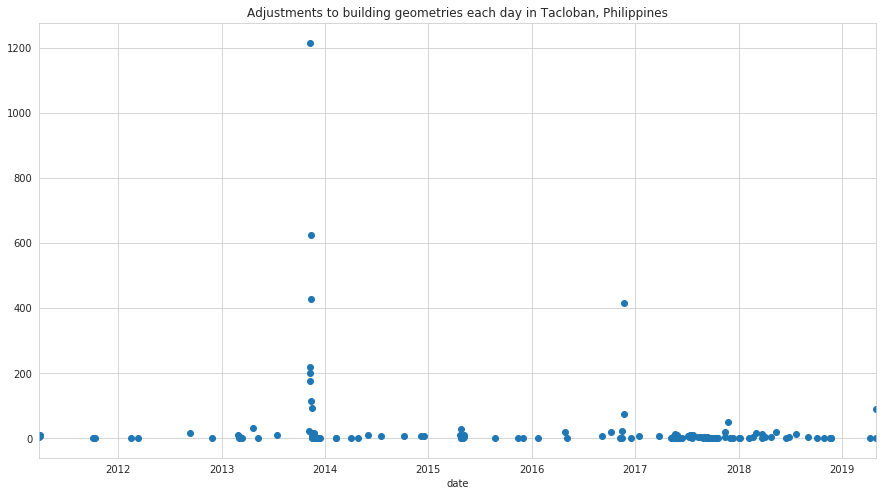

In [143]:
ax = buildings[buildings.minor_version>0].groupby('date').aggregate('count')['id'].plot(style="o", figsize=(15,8))
ax.set_title("Adjustments to building geometries each day in Tacloban, Philippines");

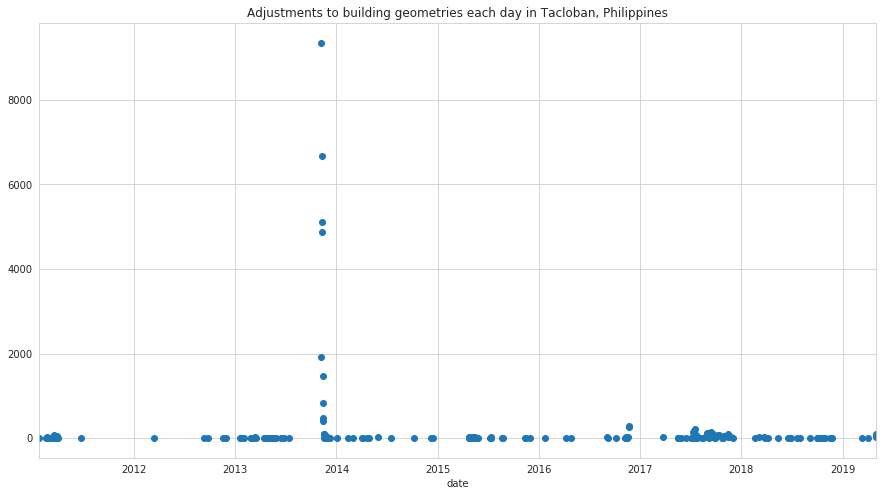

In [144]:
ax = buildings[buildings.version==1].groupby('date').aggregate('count')['id'].plot(style="o", figsize=(15,8))
ax.set_title("Adjustments to building geometries each day in Tacloban, Philippines");

In [145]:
# What is the most edited building in Tacloban?
most_edited_building = pd.DataFrame(buildings[buildings.id==buildings.sort_values(
    by='version',ascending=False).id.values[0]].sort_values(
      by=['version','minor_version'],ascending=False))

print("most edited building: http://openstreetmap.org/way/{}".format(most_edited_building.id.values[0]))

most_edited_building.head()

most edited building: http://openstreetmap.org/way/119984693


,id,type,geom,b_tags,changeset,updated,valid_until,version,minor_version,id.1,uid,user,c_tags,date,lifespan
33093,119984693,2,"POLYGON ((125.0082895 11.2071619, 125.0084121 ...","{shop=mall, name=Robinsons Place Tacloban, bui...",52197528,2017-09-20 03:58:58.000,NaN,17,1,52197528,1645185,RoyalKnight,"{host=https://www.openstreetmap.org/edit, imag...",2017-09-20,NaT
70093,119984693,2,"POLYGON ((125.0082895 11.2071559, 125.0084121 ...","{shop=mall, name=Robinsons Place Tacloban, bui...",45206815,2017-01-16 05:14:50.000,2017-09-20 03:58:58.000,17,0,45206815,1645185,RoyalKnight,"{host=https://www.openstreetmap.org/id, imager...",2017-01-16,246 days 22:44:08
46745,119984693,2,"POLYGON ((125.0082895 11.2071559, 125.0084121 ...","{shop=mall, name=Robinsons Place Tacloban, bui...",45206762,2017-01-16 05:10:18.000,2017-01-16 05:14:50.000,16,0,45206762,1645185,RoyalKnight,"{host=https://www.openstreetmap.org/id, imager...",2017-01-16,0 days 00:04:32
57780,119984693,2,"POLYGON ((125.0082895 11.2071559, 125.0084121 ...","{addr:housenumber=4-A mercedes, shop=mall, nam...",45206674,2017-01-16 05:01:07.000,2017-01-16 05:10:18.000,15,0,45206674,1645185,RoyalKnight,"{host=https://www.openstreetmap.org/id, imager...",2017-01-16,0 days 00:09:11
29433,119984693,2,"POLYGON ((125.0070106 11.2086772, 125.0067646 ...","{addr:housenumber=4-A mercedes, shop=mall, nam...",45206487,2017-01-16 04:43:54.000,2017-01-16 05:01:07.000,14,0,45206487,1645185,RoyalKnight,"{host=https://www.openstreetmap.org/id, imager...",2017-01-16,0 days 00:17:13


In [146]:
# Extending that, which buildings were edited by the most people?
buildings.groupby('id').aggregate({
    'uid':pd.Series.nunique,
    'version':pd.Series.max,
    'lifespan': pd.Series.mean
}).sort_values(by='uid',ascending=False).head()

,uid,version,lifespan
id,,,
119984693,11,17,115 days 23:45:37.473684
208504285,9,8,276 days 11:47:34.625000
105270169,9,7,305 days 23:21:44.111111
104946269,9,7,305 days 05:53:05.875000
245223918,9,9,99 days 18:37:37.750000
